# Tutorial 3: Capacity expansion

## Introduction

This tutorial demonstrates how to perform capacity expansion modeling using PyPSA (Python for Power System Analysis). We'll build a simple power system model that optimizes the deployment of renewable energy sources (wind and solar) along with storage capacity to meet electricity demand at minimum cost.

## Data preparation
First, we need to prepare our input data. We'll process load data and renewable generation profiles.

### Step 1: Load data processing

In [ ]:
# imports and settings for the plotting
from pypsa import Network
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook", style="white")
plt.rc("axes.spines", top=False, right=False)

In [2]:
# Load the data
RAW_FILE = "data/merit_order.csv"
OUTPUT_FILE = "data/load.csv"
NORMALIZE = False
RESET_INDEX_YEAR = 2019

data = pd.read_csv(RAW_FILE, index_col=0, header=0)
data = data[[col for col in data.columns if ".input" in col]].sum(axis=1)

if NORMALIZE:
    data = data / data.max()

if RESET_INDEX_YEAR:
    data.index = pd.date_range(
        start=f"{RESET_INDEX_YEAR}-01-01", periods=len(data), freq="h"
    )

data = data.to_frame()
data.index.name = "time"
data.columns = ["load"]
data.to_csv(OUTPUT_FILE)

### Step 2: Combining timeseries data

We combine the timeseries to an uniform data format for ease of use in our optimisation model. 

In [3]:
# Load the data files

LOAD_FP = "data/load.csv"
SOLAR_FP = "data/solar.csv"
WIND_FP = "data/wind.csv"


load_data = pd.read_csv(
    LOAD_FP, index_col=0, parse_dates=True, header=0, names=["load"]
)
solar_data = pd.read_csv(SOLAR_FP, header=0)
wind_data = pd.read_csv(WIND_FP, header=0)

# Combine based on load timestamps
combined_data = pd.DataFrame(index=load_data.index)
combined_data.index.name = "time"
combined_data["load"] = load_data["load"]
combined_data["solar"] = solar_data["electricity"].values
combined_data["wind"] = wind_data["electricity"].values

# Save the combined timeseries
combined_data.to_csv("data/timeseries.csv")

ts = combined_data

## Network creation and optimization
Now we'll create our network model. We'll analyze three different scenarios with varying cost ratios between generation and storage. We will first define some functions that reuse. 

In [4]:
def create_network(
    ts,
    costs,
    generation_cost_multiplier=1.0,
    storage_cost_multiplier=1.0,
    add_flow_battery=False,
    limit_renewable_energy=False,
) -> Network:

    # Adjust costs based on multipliers
    costs.loc[["wind", "solar"], "capital_cost"] *= generation_cost_multiplier
    costs.loc[
        ["battery inverter", "battery storage"], "capital_cost"
    ] *= storage_cost_multiplier

    # initialize network
    n = Network()
    n.set_snapshots(ts.index)
    n.add("Bus", "electricity")

    # add load
    n.add(
        "Load",
        "demand",
        bus="electricity",
        p_set=ts.load,
    )

    # add solar and wind
    tech_limits = {
        "wind": 150e3,
        "solar": 300e3,
    }
    for tech in ["wind", "solar"]:
        n.add(
            "Generator",
            tech,
            bus="electricity",
            p_max_pu=ts[tech],
            capital_cost=costs.at[tech, "capital_cost"],
            marginal_cost=costs.at[tech, "marginal_cost"],
            p_nom_extendable=True,
            p_nom_max=tech_limits[tech] if limit_renewable_energy else None,
        )

    # add short-duration battery storage
    EP_RATIO = 6
    n.add(
        "StorageUnit",
        "battery storage",
        bus="electricity",
        max_hours=EP_RATIO,
        capital_cost=costs.at["battery inverter", "capital_cost"]
        + EP_RATIO * costs.at["battery storage", "capital_cost"],
        efficiency_store=costs.at["battery inverter", "efficiency"],
        efficiency_dispatch=costs.at["battery inverter", "efficiency"],
        p_nom_extendable=True,
        cyclic_state_of_charge=True,
    )

    if add_flow_battery:
        # add long-duration flow battery
        FLOW_EP_RATIO = 100
        n.add(
            "StorageUnit",
            "flow battery",
            bus="electricity",
            max_hours=FLOW_EP_RATIO,
            capital_cost=costs.at["flow battery power", "capital_cost"]
            + FLOW_EP_RATIO * costs.at["flow battery energy", "capital_cost"],
            efficiency_store=costs.at["flow battery power", "efficiency"],
            efficiency_dispatch=costs.at["flow battery power", "efficiency"],
            p_nom_extendable=True,
            cyclic_state_of_charge=True,
        )

    return n

### Baseline scenario analysis

For the baseline scenario, we assume only lithium ion batteries to be available. 

In [ ]:
# load the cost data
COSTS_FP = "data/costs.csv"
SOLVER_OPTIONS = {
    "primal_feasibility_tolerance": 1e-5,
    "dual_feasibility_tolerance": 1e-5,
}
# we decrease the tolerance to speed up the optimization (default is 1e-7)

costs = pd.read_csv(COSTS_FP, index_col=0, header=0)

n = create_network(ts, costs, add_flow_battery=False)

n.optimize(
    solver_name="highs",
    solver_options=SOLVER_OPTIONS,
)

/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/pypsa/io.py:1096: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(attrs["default"].to_dict())
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/pypsa/io.py:1096: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(attrs["default"].to_dict())
Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
/home/thesethtruth/.cache/pypoetry/vir

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 6e+00]
  Cost   [5e-01, 2e+03]
  Bound  [0e+00, 0e+00]
  RHS    [2e+04, 1e+05]
Presolving model
56913 rows, 39396 cols, 144459 nonzeros  0s
56913 rows, 39396 cols, 144459 nonzeros  0s
Presolve : Reductions: rows 56913(-48210); columns 39396(-4407); elements 144459(-52617)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(2.88434e+08) 0s
      20220     8.4002676480e+08 Pr: 13419(2.8302e+11); Du: 0(0.000685162) 6s
      36450     1.2025215527e+09 Pr: 0(0); Du: 0(1.21225e-12) 10s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-mrkpyvip
Model status        : Optimal
Simplex   iterations: 36450
Objective value     :  1.2025215527e+09
Relative P-D gap    :  2.7757174913e-15
HiGHS run time      :         10.1

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43803 primals, 105123 duals
Objective: 1.20e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

#### Plot the energy system configuration

Text(0, 0.5, 'Capacity (GW)')

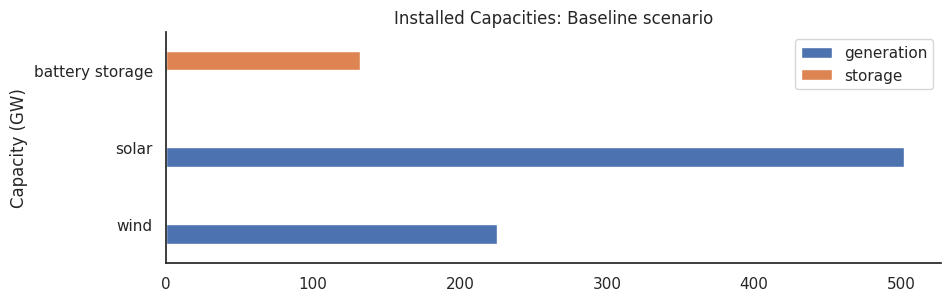

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.subplots_adjust(hspace=0.4)

capacity_data = pd.concat(
    [
        n.generators.p_nom_opt,
        n.storage_units.p_nom_opt,
    ],
    axis=1,
).div(1e3)

capacity_data.columns = ["generation", "storage"]

capacity_data.plot(kind="barh", ax=ax)
ax.set_title("Installed Capacities: Baseline scenario")
ax.set_ylabel("Capacity (GW)")

The baseline scenario shows very large capacities;
 - 500 GW solar
 - 230 GW wind 
 - and 130 GW storage 
 
These values exceed what could physically fit in the Netherlands. This oversizing occurs because our model treats the Netherlands as an isolated system without connections to neighboring countries, requiring full self-sufficiency in power generation. 

### Baseline with renewable generation limits

In [7]:
n = create_network(ts, costs, add_flow_battery=False, limit_renewable_energy=True)

n.optimize(
    solver_name="highs",
    solver_options=SOLVER_OPTIONS,
)

Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - primal_feasibility_tolerance: 1e-05
 - dual_feasibility_tolerance: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 65.59it/s]
INFO:linopy.io: Writing time: 0.51s


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 6e+00]
  Cost   [5e-01, 2e+03]
  Bound  [0e+00, 0e+00]
  RHS    [2e+04, 3e+05]
Presolving model
56913 rows, 39396 cols, 144459 nonzeros  0s
56913 rows, 39396 cols, 144459 nonzeros  0s
Presolve : Reductions: rows 56913(-48212); columns 39396(-4407); elements 144459(-52619)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(2.88434e+08) 0s
       9002     2.2174740770e+08 Pr: 11220(4.14063e+10); Du: 0(0.000391046) 7s
      39571     1.7644238200e+09 Pr: 0(0); Du: 0(6.7335e-13) 10s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-6ce4rl96
Model status        : Optimal
Simplex   iterations: 39571
Objective value     :  1.7644238200e+09
Relative P-D gap    :  2.9051973753e-14
HiGHS run time      :         10.3

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43803 primals, 105125 duals
Objective: 1.76e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Writing the solution to /tmp/linopy-solve-ull82aq8.sol


('ok', 'optimal')

#### Plot the energy system configuration

Text(0, 0.5, 'Capacity (GW)')

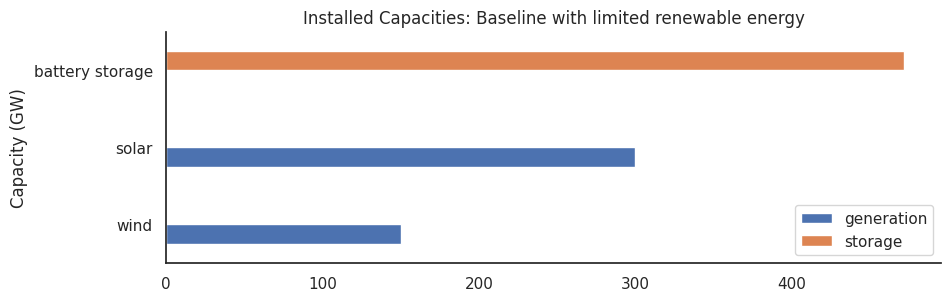

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.subplots_adjust(hspace=0.4)

capacity_data = pd.concat(
    [
        n.generators.p_nom_opt,
        n.storage_units.p_nom_opt,
    ],
    axis=1,
).div(1e3)

capacity_data.columns = ["generation", "storage"]

capacity_data.plot(kind="barh", ax=ax)
ax.set_title("Installed Capacities: Baseline with limited renewable energy")
ax.set_ylabel("Capacity (GW)")

#### Impact of generation capacity limits

With upper limits applied to renewable generation, we see:

- 300 GW solar (at limit)
- 150 GW (at limit)
- 480 GW lithium-ion battery storage

The model responds to these generation constraints by heavily investing in storage capacity. This shift reveals a key system dynamic: when prevented from oversizing generation, the model compensates with massive storage deployment. However, with lithium-ion batteries limited to 6 hours of storage duration, this solution may struggle to bridge extended periods of low renewable generation, suggesting the need for longer-duration storage technologies.

### Baseline with renewable generation limits and flow battery scenario

In this scenario, in addition to the upper limit imposed on renewable energy generation we also assume also flow batteries are available for energy storage.

In [9]:
n = create_network(ts, costs, add_flow_battery=True, limit_renewable_energy=True)

n.optimize(
    solver_name="highs",
    solver_options=SOLVER_OPTIONS,
)

Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - primal_feasibility_tolerance: 1e-05
 - dual_feasibility_tolerance: 1e-05
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 64.36it/s]
INFO:linopy.io: Writing time: 0.71s


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+02]
  Cost   [5e-01, 3e+03]
  Bound  [0e+00, 0e+00]
  RHS    [2e+04, 3e+05]
Presolving model
91953 rows, 65677 cols, 249579 nonzeros  0s
91953 rows, 65677 cols, 249579 nonzeros  0s
Presolve : Reductions: rows 91953(-74493); columns 65677(-4407); elements 249579(-78900)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.83545e+08) 0s
      12160     1.8623553094e+08 Pr: 14874(3.04767e+10); Du: 0(0.00164249) 6s
      18075     1.8738298523e+08 Pr: 17422(9.16745e+10); Du: 0(0.00227149) 11s
      23161     1.8881790897e+08 Pr: 19606(1.58739e+11); Du: 0(0.00280235) 17s
      27088     1.8986007861e+08 Pr: 21214(2.07089e+11); Du: 0(0.00374331) 23s
      28739     3.1744926814e+08 Pr: 21302(2.66921e+11); Du: 0(0.00379979) 29s
      31281     3.67793059

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70084 primals, 166446 duals
Objective: 1.18e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Relative P-D gap    :  7.4476445564e-15
HiGHS run time      :         68.54
Writing the solution to /tmp/linopy-solve-jdtj8wnz.sol


('ok', 'optimal')

#### Plot the energy system configuration

Text(0, 0.5, 'Capacity (GW)')

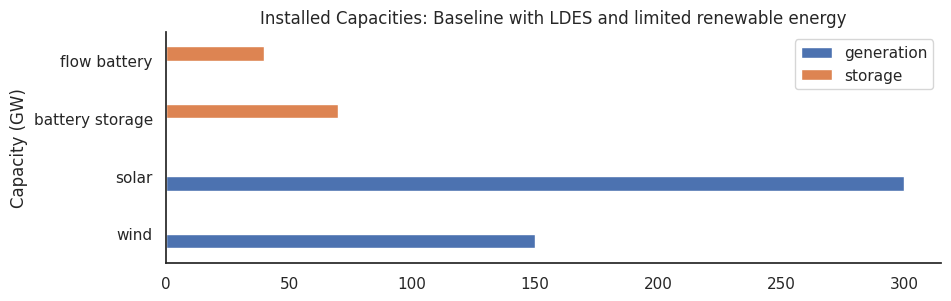

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.subplots_adjust(hspace=0.4)

capacity_data = pd.concat(
    [
        n.generators.p_nom_opt,
        n.storage_units.p_nom_opt,
    ],
    axis=1,
).div(1e3)

capacity_data.columns = ["generation", "storage"]

capacity_data.plot(kind="barh", ax=ax)
ax.set_title("Installed Capacities: Baseline with LDES and limited renewable energy")
ax.set_ylabel("Capacity (GW)")

#### Impact of adding long-duration energy storage
After adding flow batteries (100-hour storage duration), the model selects:
- 300 GW solar (at limit)
- 150 GW wind (at limit)
- 80 GW battery electric storage
- 40 GW flow battery storage

The introduction of long-duration energy storage (LDES) reduces the need for short-duration batteries by about 80%. The model opts for a mix of both storage types, using flow batteries to manage multi-day supply gaps while keeping some battery capacity for daily cycling. This more diversified storage portfolio better matches the temporal patterns of renewable generation.

## Sensitivity analysis

### Define scenarios and run the optimisation problems

In [21]:
# Create and solve networks with different cost scenarios
scenarios = {
    "baseline": (1.0, 1.0),
    "expensive_generation": (2.0, 1.0),
    "expensive_storage": (1.0, 2.0),
}

results = {}
for name, (gen_mult, store_mult) in scenarios.items():
    n = create_network(
        ts,
        costs,
        gen_mult,
        store_mult,
        add_flow_battery=True,
        limit_renewable_energy=True,
    )
    n.optimize(solver_name="highs", solver_options=SOLVER_OPTIONS)
    results[name] = n



Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 62.47it/s]
INFO:linopy.io: Writing time: 0.71s


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+02]
  Cost   [5e-01, 3e+03]
  Bound  [0e+00, 0e+00]
  RHS    [2e+04, 3e+05]
Presolving model
91953 rows, 65677 cols, 249579 nonzeros  0s
91953 rows, 65677 cols, 249579 nonzeros  0s
Presolve : Reductions: rows 91953(-74493); columns 65677(-4407); elements 249579(-78900)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.83545e+08) 0s
      10829     2.0078874152e+08 Pr: 14636(2.96392e+10); Du: 0(4.13542e-07) 6s
      16531     2.0202901339e+08 Pr: 17102(8.63049e+10); Du: 0(4.61548e-07) 12s
      20973     2.0332679358e+08 Pr: 18945(1.47268e+11); Du: 0(4.98494e-07) 18s
      23935     2.0449526677e+08 Pr: 20233(2.00132e+11); Du: 0(5.80821e-07) 26s
      26806     3.6180356239e+08 Pr: 20026(6.98268e+10); Du: 0(5.13956e-07) 32s
      30325     6.411

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70084 primals, 166446 duals
Objective: 1.38e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas o

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+02]
  Cost   [5e-01, 4e+03]
  Bound  [0e+00, 0e+00]
  RHS    [2e+04, 3e+05]
Presolving model
91953 rows, 65677 cols, 249579 nonzeros  0s
91953 rows, 65677 cols, 249579 nonzeros  0s
Presolve : Reductions: rows 91953(-74493); columns 65677(-4407); elements 249579(-78900)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.83545e+08) 0s
       8252     2.0049896311e+08 Pr: 13451(1.22835e+10); Du: 0(4.37567e-07) 7s
      14345     2.0176564085e+08 Pr: 16114(6.23753e+10); Du: 0(6.55286e-07) 12s
      19348     2.0316815075e+08 Pr: 18332(1.16312e+11); Du: 0(7.37611e-07) 17s
      22671     2.0435855010e+08 Pr: 19794(1.58931e+11); Du: 0(6.86099e-07) 23s
      26180     3.6144549772e+08 Pr: 19491(4.88207e+10); Du: 0(6.3827e-07) 29s
      29998     7.5960

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70084 primals, 166446 duals
Objective: 1.80e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Writing the solution to /tmp/linopy-solve-vprnh_4_.sol


Index(['electricity'], dtype='object', name='Bus')
Index(['electricity'], dtype='object', name='Bus')
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/linopy/common.py:154: UserWarning: coords for dimension(s) ['Generator'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.
  warn(
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 6/6 [00:00<00:00, 58.06it/s]
INFO:linopy.io: Writing time: 0.72s


Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+02]
  Cost   [5e-01, 6e+03]
  Bound  [0e+00, 0e+00]
  RHS    [2e+04, 3e+05]
Presolving model
91953 rows, 65677 cols, 249579 nonzeros  0s
91953 rows, 65677 cols, 249579 nonzeros  0s
Presolve : Reductions: rows 91953(-74493); columns 65677(-4407); elements 249579(-78900)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.83545e+08) 0s
      12454     2.0499658269e+08 Pr: 13011(6.39438e+10); Du: 0(1.02538e-07) 6s
      17279     2.0729501908e+08 Pr: 14535(1.45605e+11); Du: 0(1.02538e-07) 14s
      21567     2.1010135268e+08 Pr: 15813(2.43517e+11); Du: 0(1.02538e-07) 19s
      25336     2.1315855408e+08 Pr: 16892(3.54561e+11); Du: 0(3.21475e-08) 24s
      28179     3.4514256131e+08 Pr: 24665(2.16081e+10) 30s
      32518     4.3559447277e+08 Pr: 3633

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70084 primals, 166446 duals
Objective: 1.86e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


## Results Analysis and Visualization

Let's analyze and compare the results from our different scenarios.

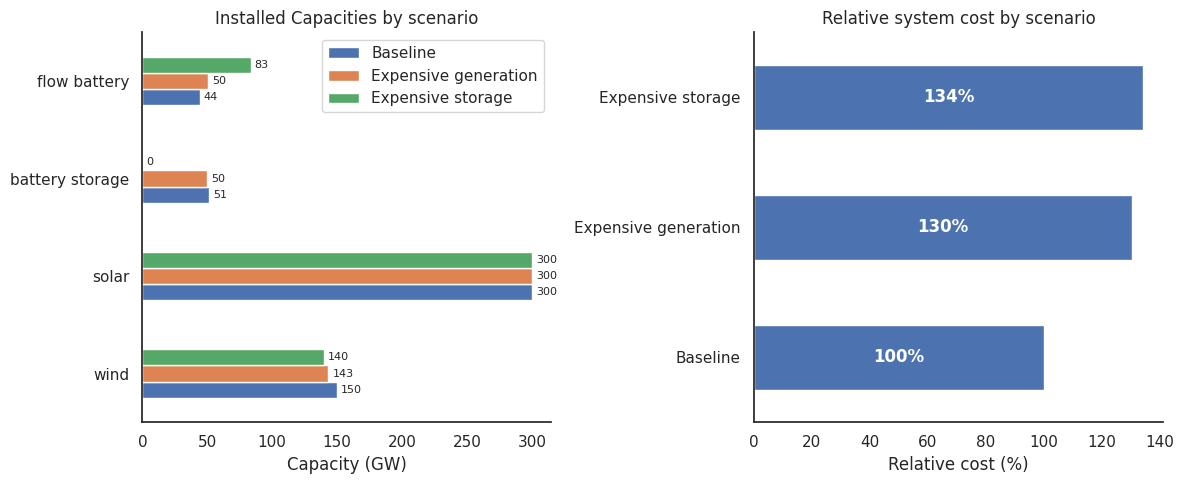

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(hspace=0.4)

# Capacity comparison
capacity_data = pd.DataFrame()
for scenario, n in results.items():
    caps = pd.concat([n.generators.p_nom_opt, n.storage_units.p_nom_opt]).rename(
        scenario
    )
    capacity_data = pd.concat([capacity_data, caps], axis=1)

# convert to GW
capacity_data = capacity_data.div(1e3)
# make scenario names pretty
capacity_data.columns = [name.replace("_", " ").capitalize() for name in capacity_data.columns]

capacity_data.plot(kind="barh", ax=axes[0])
axes[0].set_title("Installed Capacities by scenario")
axes[0].set_xlabel("Capacity (GW)")

# Add data call outs
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.0f', label_type='edge', fontsize=8, padding=3)

# Cost comparison
cost_data = pd.DataFrame(
    {name: n.objective for name, n in results.items()}, index=["Relative System Cost"]
).T.div(1e9)

# Normalize to baseline
cost_data = cost_data.div(cost_data.loc["baseline"]).mul(100)
# make index pretty
cost_data.index = [name.replace("_", " ").capitalize() for name in cost_data.index]

cost_data.plot(kind="barh", ax=axes[1], legend=False)
axes[1].set_title("Relative system cost by scenario")
axes[1].set_xlabel("Relative cost (%)")

for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.0f%%", label_type="center", fontsize=12, color="white", fontweight="bold")

plt.tight_layout()

#### Sensitivity analysis results
Comparing three cost scenarios reveals clear system adaptation patterns:
- In the baseline scenario (renewable and storage costs at reference values), the model deploys 150 GW wind, 300 GW solar, with a mixed storage portfolio of 51 GW batteries and 44 GW flow batteries.
- When **generation costs double**, wind capacity slightly decreases to 143 GW while solar remains at its 300 GW limit. Storage capacities remain similar (50 GW batteries, 50 GW flow), suggesting storage deployment is relatively insensitive to generation costs. Total system costs increase by 30%.
- With **doubled storage costs**, the model shifts notably. While solar remains capped and wind drops slightly to 140 GW, battery storage is completely phased out in favor of increased flow battery capacity (83 GW). This suggests flow batteries' longer duration becomes more valuable when storage is expensive. The scenario results in the highest cost increase at 34% above baseline. Interestingly, the deployed wind capacity is more sensitive towards the costs of storage than towards the cost of generation.

### Detailed analysis of system dynamics
We might be interested in specific system dynamics of one of the scenarios during a specific week. Remember the first chapter of this tutorial? We found that February has a long period of high demand due to heating. Let's see how each of the energy system configurations fares during this period. 

/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)
/home/thesethtruth/.cache/pypoetry/virtualenvs/esi-course-6syH-QiP-py3.12/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


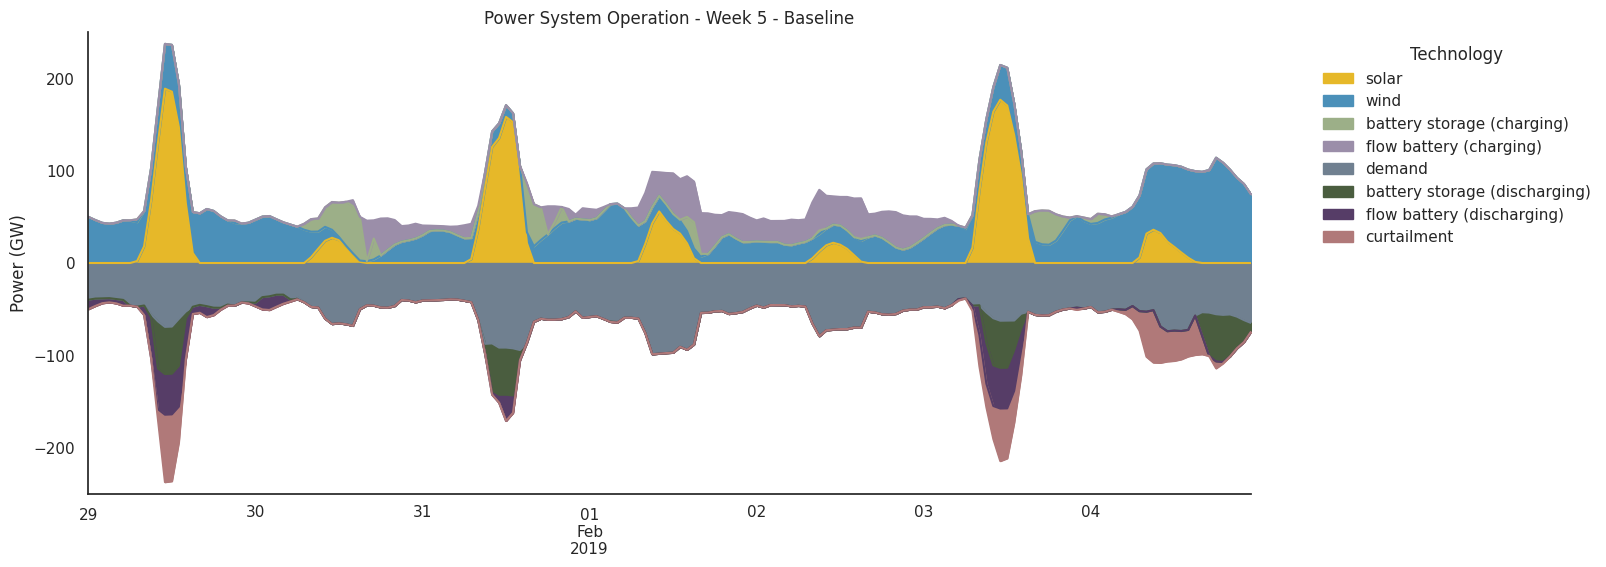

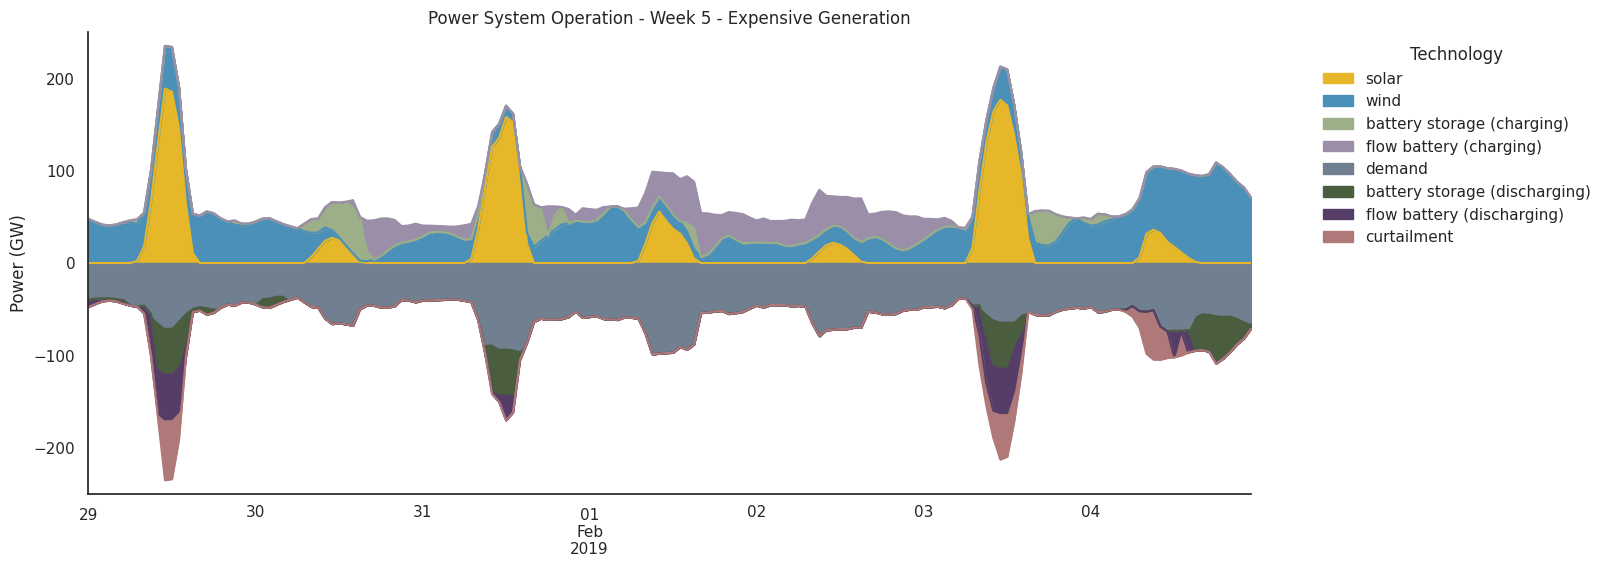

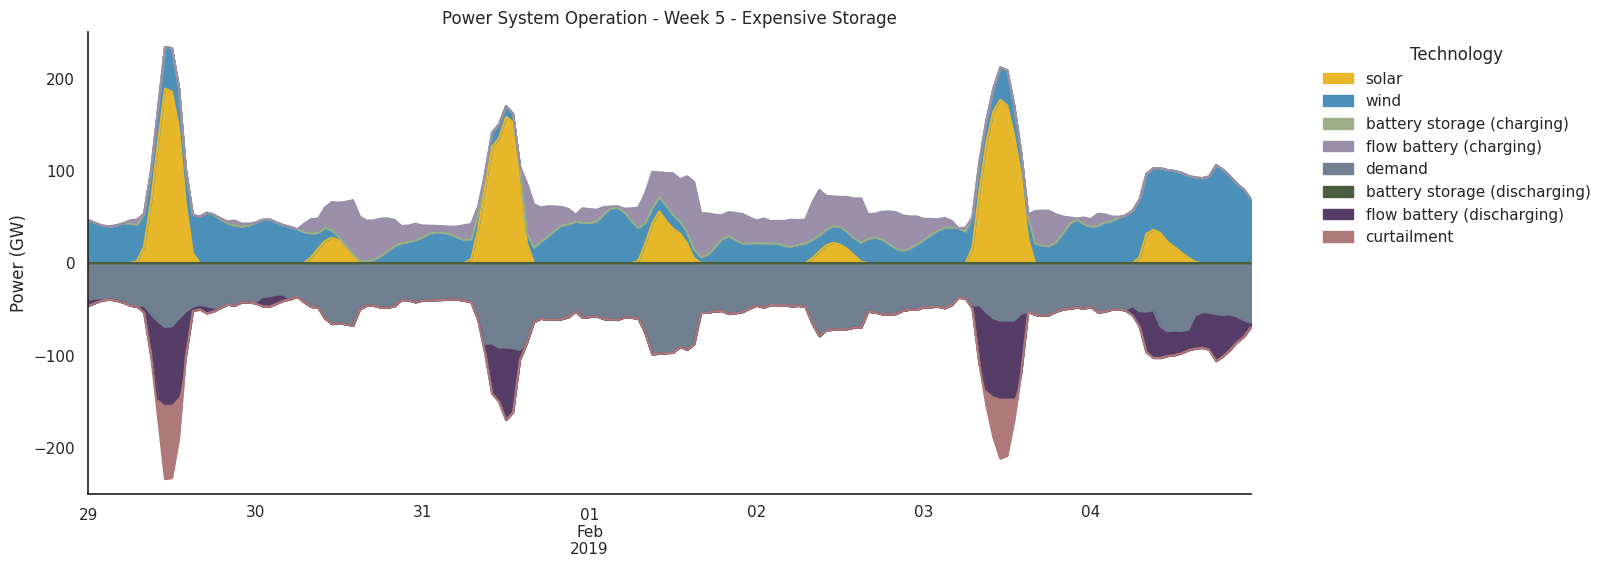

In [109]:
def plot_timeseries(network, scenario_name, week_start=0):
    week_slice = slice(week_start * 168, (week_start + 1) * 168)

    fig, ax = plt.subplots(figsize=(15, 6))

    # slice the generation data
    generation = network.generators_t.p_max_pu[week_slice] * network.generators.p_nom_opt
    storage = network.storage_units_t.p[week_slice]
    load = network.loads_t.p[week_slice]

    # extract the negative and positive parts of the storage
    storage_negative = storage.copy()
    storage_negative[storage > 0] = 0
    storage_negative.columns = [
        f"{col} (discharging)" for col in storage_negative.columns
    ]

    storage_positive = storage.copy()
    storage_positive[storage < 0] = 0
    storage_positive.columns = [f"{col} (charging)" for col in storage_positive.columns]

    # combine the parts to positive and negative timeseries (on the bus)
    positives = pd.concat([generation, storage_positive], axis=1).div(1e3)
    negatives = pd.concat([-load, storage_negative], axis=1).div(1e3)

    curtailment = -(positives.sum(axis=1) + negatives.sum(axis=1))
    curtailment[curtailment > 0] = 0
    curtailment.name = "curtailment"

    negatives = pd.concat([negatives, curtailment], axis=1)

    # Define colors for each technology
    colors = {
        "wind": "#4B90B9",
        "solar": "#E6B829",
        "demand": "#708090",
        "battery storage (charging)": "#9CAF88",
        "battery storage (discharging)": "#4A5D3F",
        "flow battery (charging)": "#9B8EA9",
        "flow battery (discharging)": "#563D67",
        "curtailment": "#B07979",
    }
    # Apply colors to the plots
    positives.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[colors.get(col, "#333333") for col in positives.columns],
    )
    negatives.plot(
        kind="area",
        ax=ax,
        stacked=True,
        color=[colors.get(col, "#333333") for col in negatives.columns],
    )

    ax.set_ylim(-250, 250)
    ax.set_title(f"Power System Operation - Week {week_start+1} - {scenario_name}")
    ax.set_ylabel("Power (GW)")
    ax.set_xlabel("")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Technology", frameon=False)

    return fig


fig = plot_timeseries(
    results["baseline"], "Baseline", week_start=4
)
fig = plot_timeseries(
    results["expensive_generation"], "Expensive Generation", week_start=4
)
fig = plot_timeseries(
    results["expensive_storage"], "Expensive Storage", week_start=4
)

## Conclusion

1. The addition of long-duration storage (flow battery) allows for better management of longer periods of low renewable generation.
2. Different cost scenarios lead to different optimal system configurations:
   - Higher generation costs result in more storage capacity to make better use of available renewable energy
   - Higher storage costs push the system toward oversized generation capacity to reduce storage needs
3. The baseline scenario represents a balanced approach between generation and storage.

## Next steps

To extend this analysis, you could:

1. Add more technology options (e.g., different storage or dispatchables technologies)
2. Analyze seasonal patterns using the full year of data
3. Include more detailed cost components (fixed O&M, variable O&M, etc.)